# Linear track demo

Here we load sorted unit data obtained from MatClust to identify putative place cells. The session has about 15 minutes of linear track running, followed by 15 minutes of rest. 

Data was recorded by _Joshua Chu_, with a Spikegadgets wireless headstage, on July 8th, 2017, from the CA! area of a male Long-Evans rat named `install`.

Notebook was created by _Etienne Ackermann_.

### Preliminaries

We use the following Python packages; they can be installed either with `conda install <pkg>` or with `pip install <pkg>`. Most of these packages are very common, and it is more than likely that you have them installed already. 

It doesn't hurt to type `pip install <pkg>` if the package is already installed, so don't be nervous to try it out!

```bash
pip install nelpy
```

**For downloading example data from the web:**
```python
1. requests   # used to download data from web
2. tqdm       # used to show progress of download
```

**the rest of this notebook:**
```python
3. numpy      # numerical powerhorse for Python
4. matplotlib # used to make plots and figures
5. scipy      # signal processing, stats, etc.; used here to smooth signals
6. sklearn    # machine learning in Python; used here to do train-test split 
              # (under the hood) when evaluating Bayesian decoding performance
```

**and of course:**
```python
7. nelpy      # Ephys object models, and analysis routines
```

Now that we have all the packages we nee, let's get started! First, we need to get the sample data...

## 1. Obtain example data

We will look for data in the `example-data\linear-track\` directory inside your current working directory. If the data doesn't exist, we will download it from https://github.com/nelpy/example-data, and save it to your local machine. 

If you already have the data, it won't be downloaded again.

In particular, we will download two files, namely
 1. `trajectory.videoPositionTracking` which is a binary file with (x,y) position coordinate pairs and timestamps, and
 2. `spikes.mat` which is a Matlab file containing information about sorted units (cells) obtained by using MatClust (https://bitbucket.org/mkarlsso/matclust).

In [1]:
import os
import requests

# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm

datadir = os.path.join(os.getcwd(), 'example-data\linear-track')
os.makedirs(datadir, exist_ok=True)

filenames = []
filenames.append(os.path.join(datadir, 'trajectory.videoPositionTracking'))
filenames.append(os.path.join(datadir, 'spikes.mat'))
urls = []
urls.append('https://github.com/nelpy/example-data/raw/master/linear-track/trajectory.videoPositionTracking')
urls.append('https://github.com/nelpy/example-data/raw/master/linear-track/spikes.mat')

for filename, url in zip(filenames, urls):
    if os.path.exists(filename):
        print('you already have the example data, skipping download...')
    else:
        print('downloading data from {}'.format(url))
        # Streaming, so we can iterate over the response.
        r = requests.get(url, stream=True)

        # Total size in bytes.
        total_size = int(r.headers.get('content-length', 0)); 
        chunk_size = 1024 # number of bytes to process at a time (NOTE: progress bar unit only accurate if this is 1 kB)

        with open(filename, 'wb+') as f:
            for data in tqdm(r.iter_content(chunk_size), total=int(total_size/chunk_size), unit='kB'):
                f.write(data)
            
        print('data saved to local directory {}'.format(filename))

filename_pos = filenames[0]
filename_spikes = filenames[1]

downloading data from https://github.com/nelpy/example-data/raw/master/linear-track/trajectory.videoPositionTracking


1395kB [00:09, 147.66kB/s]                                                     


data saved to local directory C:\temp\example-analyses\example-data\linear-track\trajectory.videoPositionTracking
downloading data from https://github.com/nelpy/example-data/raw/master/linear-track/spikes.mat


173kB [00:00, 366.92kB/s]                                                      


data saved to local directory C:\temp\example-analyses\example-data\linear-track\spikes.mat


## 2. Import packages

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import struct

import nelpy as nel
import nelpy.io
import nelpy.plotting as npl

# assume default aesthetics
npl.setup()

%matplotlib inline

## 3. Extract position data

The position data is stored in a binary file, and we already made a reference to it as `filename_pos`, which should point to `./example-data/linear-track/trajectory.videoPositionTracking`, inside your current working directory.

More information about the format of the file can be obtained at https://github.com/nelpy/example-data/tree/master/linear-track .

Here we define a simple function to read the plaintext header from the file, since the header also informs us of the format of the rest of the data.

In [3]:
def print_header(filename, timeout=50):
    """Reads header lines from a SpikeGadgets .rec file, and prints it to screen."""
    linecount = 0
    with open(filename, 'rb') as fileobj:
        instr = fileobj.readline()
        linecount += 1
        while (instr != b'<End settings>\n') :
            print(instr)
            instr = fileobj.readline()
            if linecount > timeout:
                break
    print(instr)

In [4]:
print_header(filename_pos)

b'<Start settings>\n'
b'threshold: 199\n'
b'dark: 0\n'
b'clockrate: 30000\n'
b'camera resolution: 640x480\n'
b'pixel scale: 0 pix/cm\n'
b'Fields: <time uint32><xloc uint16><yloc uint16><xloc2 uint16><yloc2 uint16>\n'
b'<End settings>\n'


Armed with this new information, we read over the header, and then extract (1) the 32 bit unsigned `timestamp`, as well as (2) the 16 bit unsigned position data into lists `x1` and `y1` (`x2` and `y2` were not used in this recording, and can be ignored).

In [5]:
n_packets = 500000
timestamps = []
x1 = []
y1 = []
x2 = []
y2 = []
ii = 0
with open(filename_pos, 'rb') as fileobj:
    instr = fileobj.readline()
    
    n_max_header_lines = 50
    hh = 0
    # consume all header lines
    while (instr != b'<End settings>\n') :
        hh +=1
        instr = fileobj.readline()
        if hh > n_max_header_lines:
            print('End of header not found! Aborting...')
            break
    for packet in iter(lambda: fileobj.read(12), ''):
        if packet:
            ts_ = struct.unpack('<L', packet[0:4])[0]
            x1_ = struct.unpack('<H', packet[4:6])[0]
            y1_ = struct.unpack('<H', packet[6:8])[0]
            x2_ = struct.unpack('<H', packet[8:10])[0]
            y2_ = struct.unpack('<H', packet[10:12])[0]
            timestamps.append(ts_)
            x1.append(x1_)
            y1.append(y1_)
            x2.append(x2_)
            y2.append(y2_)
        else:
            break
        if ii >= n_packets:
            print('Stopped before reaching end of file')
            break

**Remark**: up to this point, we have not used `nelpy` yet. We have our position as two lists `x1` and `y1`, along with a list of `timestamps`. But working with these lists of coordinates and timestamps directly can be tedious and error-prone. Consequently, we will wrap the data into `nelpy` objects to make our life easier.

### 3.a) Get session boundaries

First, we will estimate epochs during which the animal was supposed to be running on the track, and those for which the animal was in its sleep box. Note that this task can be a little tricky to estimate directly from the data, since the animal is not always running while on the track, and may in fact just be stationary for significant periods.

We can (and probably should) of course get the experimantal epochs (that of running on the track, and that of resting in the sleep box) from our lab notes, but it's always good to make sure that your data agrees with your notes, and moreover, it demonstrates how we can use `nelpy` to estimate these epochs in case our notes were lost, or inaccurate.

In [6]:
# we estimate large periods of inactivity as periods where the animal's estimated position did not move for at least 10 seconds
minLength = 600 # 10 seconds @ 60 fps
bounds, _, _ = nel.utils.get_events_boundaries(np.gradient(x1),
                                               PrimaryThreshold=0, 
                                               SecondaryThreshold=0, 
                                               mode='below', 
                                               minLength=minLength, 
                                               ds=1
                                              )

# bounds are now in sample numbers, so we convert them to time using timestamps
FS = 30000
bounds_ts = np.zeros(bounds.shape)
for row in range(len(bounds)):
    for col in range(2):
        bounds_ts[row,col] = timestamps[bounds[row,col]]
        


Here we've used `nelpy` to get event boundaries, in sample numbers, where the animal spent at least 10 seconds with zero change in its `x1` coordinate. We could do this, because the tracker does not track the animal when it is in the sleep box (it is outside of the camera's view).

Next, we create our first `nelpy` object, namely an `EpochArray` containing all the epochs defined by the bounds returned above.

In general it is not necessary to sort epochs like we do below, but we have to do that here because the way we build our `session_epochs` is a little convoluted: we build it by first estimating sleep box epochs, and then combine the sleep box epochs with the complement of the sleep box epochs. When we take a union of epochs, they are no longer guaranteed to be in sorted order, and so we sort them for good measure.

In [7]:
sleep_box = nel.EpochArray(bounds_ts/FS, domain=nel.EpochArray((timestamps[0]/FS, timestamps[-1]/FS)))
session_epochs = (sleep_box + ~sleep_box) # the entire session includes when the animal was in its sleep box, 
                                # and when it was not(~) in its sleep box
session_epochs._sort()

We can always inspect `nelpy` objects by printing them to screen like so:

In [8]:
print(session_epochs)

<EpochArray at 0x2c54ca41e48: 3 epochs> of duration 33:02:423 minutes


which tells us that we have 3 epochs, with a total duration of approximately 30 minutes. 

HOWEVER! We expected to only have two epochs! One 15 minute run, followed by a 15 minute sleep box session. So what happened? Well, we can have a closer look at the epochs, by printing out their durations:

In [9]:
for ep in session_epochs:
    print(ep.duration)

25.8235 seconds
15:59:115 minutes
16:37:485 minutes


We see that the first epoch is only about 25 seconds long, and this corresponds to when we moved the animal onto the track, so we're happy to ignore that particular epoch, and focus on the other two.

Note also that `nelpy` returned a nice human readable duration for each epoch. Under the hood, the durations are stored (calculated, more accurately) in seconds, and we could have computed it ourselves like so:

In [10]:
print(session_epochs.time) # .time returns the bounds defining the epochs, in seconds; each row is [start, stop]

[[ 4397.0317      4422.85523333]
 [ 4422.85523333  5381.9703    ]
 [ 5381.9703      6379.4556    ]]


In [11]:
print(session_epochs.time[:,1] - session_epochs.time[:,0]) # durations are stops - starts

[  25.82353333  959.11506667  997.4853    ]


We see that the durations that we computed above agree with the ones we printed out earlier, but 15:59:115 minutes is arguably easier to parse than 959.11506667 seconds.

In fact, we don't even really need to call `print()` on many of the objects, and we can just invoke them to see a representation of the objects. Let's try that on our `sleep_box` object:

In [12]:
sleep_box

<EpochArray at 0x2c55026de48: 2 epochs> of duration 17:03:308 minutes

We see that (as we already know) there are two epochs during which we think the animal was in its sleep box, namely the first 25 seconds, and then the last 16 minutes of the recording session.

We can similarly look at the complement of the sleep box epochs, which should then be (naturally) when the animal was on the linear track:

In [13]:
~sleep_box

<EpochArray at 0x2c550260320: 1 epoch> of duration 15:59:115 minutes

### 3.b) Create 2D trajectory object

Next we will use our lists `x1` and `y1` to build a `nelpy` `AnalogSignalArray`. This is pretty easy: we pass in the position coordinates as a 2 x n_samples array, along with the corresponding timestamps, and we specify that we want this object to be defined on the epoch where the animal was NOT in its sleep box, i.e., when the animal was on the track.

Note also that we defined the trajectory object on a slightly smaller epoch, namely we shrunk the epoch by 20 seconds from both directions. We did this in order to be sure that the first and last parts of the trajectory were not those where we were moving the animal onto and off of the track.

In [14]:
pos = nel.AnalogSignalArray(np.vstack((x1, y1)), timestamps=np.array(timestamps)/FS, support=(~sleep_box).shrink(20), fs=60)

c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


In [15]:
pos # inspect pos object to see if everything looks good

<AnalogSignalArray at 0x2c5519c3240: 2 signals> for a total of 15:19:115 minutes

We can plot the position/trajectory object like so:

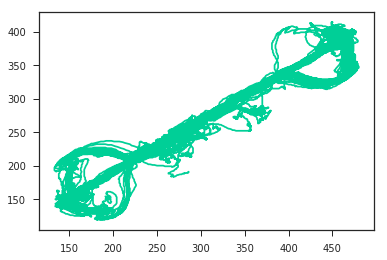

In [16]:
npl.plot2d(pos) # plot the entire trajectory

Recall that the linear track epoch ranged from approcimately 4420 to 5380 seconds (We can always get these by simply inspecting pos again, like blow):

In [17]:
pos.support.time # print the time boundaries on which pos is deifned

array([[ 4442.85523333,  5361.9703    ]])

and so we can easily plot the trajectory, say, for the first 30 seconds while the animal was on the track. One way to do this, is to define an epoch, and then to restrict the position object to that newly defined epoch. Let's do this now:

In [18]:
ep = nel.EpochArray([4442, 4472])
ep

<EpochArray at 0x2c551a46940: 1 epoch> of duration 30 seconds

c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


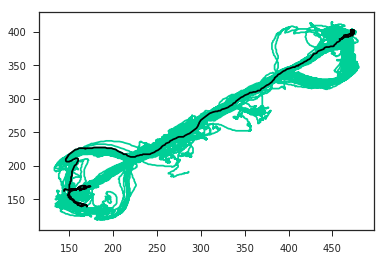

In [19]:
npl.plot2d(pos) # plot the entire trajectory
npl.plot2d(pos[ep], color='k') # plot pos restricted to ep

This way of filtering / restricting the data is very powerful, and we will use it later on to get spikes only during times when the animal was running faster than some threshold, and so on.

Before we move onto the next phase (linearization), let's take a quick aside to make the plot above a bit nicer. First, we may want to set the aspect ratio to equal, and we may also want to add titles, labels, etc. We may even want to smooth the trajectory.

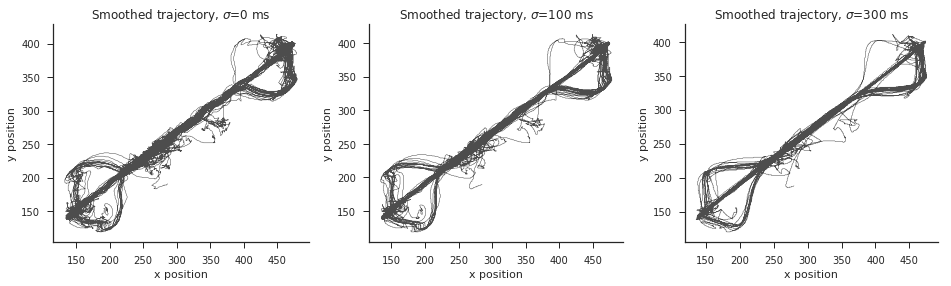

In [20]:
sigmas = [0, 0.1, 0.3] # smooth trajectory in time, with sigma = 100 ms (=0.1 seconds)

fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for sigma, ax in zip(sigmas, axes):
    npl.plot2d(pos.smooth(sigma=sigma), lw=0.5, color='0.3', ax=ax)
    ax.set_aspect('equal')  
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    npl.utils.clear_right(ax)
    npl.utils.clear_top(ax)
    ax.set_title('Smoothed trajectory, $\sigma$={} ms'.format(round(sigma*1000)))

### 3.c) Linearize position

We can do the rest of our analysis in 2D, but sometimes it's nicer to linearize the position data first. Here, we simply use PCA (a dimensionality reduction technique) to find the direction of maximal variance in our position data, and we use this as our new 1D linear track axis.

**NOTE**: To use PCA from scikit-learn, we need to provide our data as an n_samples x n_features matrix. The internal representation of the `nelpy` `AnalogSignalArray` can actually be changed, but we can always explicitly ask to get the underlying data back in a particular format. We do this, by asking for `_ydata_colsig`, which means that we want each feature (or signal, or component) to be a column of the data matrix. Here you shouldn't be concerned with the favt that we asked for `_ydata`: this is simply an internal naming convention of the `AnalogSignalArray`, and has nothing to do with our `x` and `y` coordinates. More precisely, `_ydata` refers to the _entire_ data matrix, in contrast to `_tdata` which stores the timestamp info. So `_ydata` contains both `x1` and `y1`.

In [21]:
from sklearn.decomposition import PCA
X = pos._ydata_colsig   # we access the 
pca = PCA(n_components=1)
Xlinear = pca.fit_transform(X)

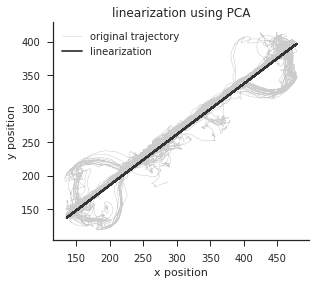

In [22]:
Xlinear_ = pca.inverse_transform(Xlinear)
ax = npl.plot2d(pos, lw=0.5, color='0.8', label='original trajectory')
plt.plot(Xlinear_[:,0], Xlinear_[:,1], color='0.2', label='linearization')
plt.legend()
ax.set_aspect('equal')  
ax.set_xlabel('x position')
ax.set_ylabel('y position')
npl.utils.clear_right(ax)
npl.utils.clear_top(ax)
ax.set_title('linearization using PCA')

We also re-scale our data to range from 0 to 100 (so that we can express movement along the track as a percentage). Typically we would actually scale our data to some physical dimension or unit, such as cm, and not pixels as we have it above, or percentage, as we're transforming it into here.

In [23]:
Xlinear = Xlinear - np.min(Xlinear)
Xlinear = (Xlinear / np.max(Xlinear))*100

We now have `Xlinear` as a scaled (0 to 100) position variable, as a numpy array. We want to put it back into a `nelpy` `AnalogSignalArray` container, so that we can slice and interogate it as before:

In [24]:
pos1d = nel.AnalogSignalArray(Xlinear, timestamps=pos.time, support=pos.support, fs=60)
print('pos:  ', pos)
print('pos1d:', pos1d)

pos:   <AnalogSignalArray at 0x2c5519c3240: 2 signals> for a total of 15:19:115 minutes
pos1d: <AnalogSignalArray at 0x2c5532d4c18: 1 signals> for a total of 15:19:115 minutes


We see that `pos1d` now only has 1 signal, as expected, and if we plot it, we can confirm that it ranges between 0 and 100:

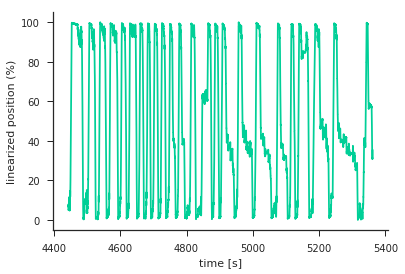

In [25]:
ax = npl.plot(pos1d)
ax.set_xlabel('time [s]')
ax.set_ylabel('linearized position (%)')
npl.utils.clear_right(ax)
npl.utils.clear_top(ax)

## 4. Extract spike times

In [26]:
mat = nel.io.matlab.load(filename_spikes)

In [27]:
# Epoch for which spikes were sorted
session_bounds = nel.EpochArray(mat['spikes'][0][0]['timerange'].ravel()[0])

In [28]:
spikes = []
ct = 0
num_array = 0
for ii, array in enumerate(mat['spikes']):
    # If empty array, that particular tetrode was not sorted
    if (array.size > 1):
        for jj, subarray in enumerate(array):
            if (subarray.size != 0):
                # Exclude tetrodes with no spikes
                if (len(subarray['time'].ravel()[0]) != 0):
                    spikes.append(subarray['time'].ravel()[0])
                    ct +=1
    elif (array.size == 1):
        if (len(array['time'].ravel()[0]) != 0):
            spikes.append(array['time'].ravel()[0])
            ct +=1
print("Found {} non-empty units total".format(ct))

Found 31 non-empty units total


In [29]:
st = nel.SpikeTrainArray(timestamps=spikes, support=session_bounds, fs=FS)
st.support

<EpochArray at 0x2c553396ef0: 1 epoch> of duration 32:48:273 minutes

In [30]:
sleep_box.domain

<EpochArray at 0x2c55026ddd8: 1 epoch> of duration 33:02:423 minutes

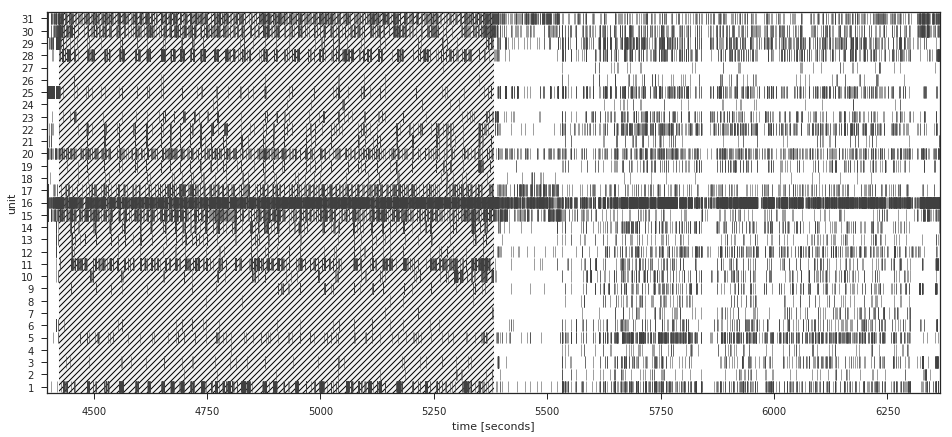

In [31]:
with npl.FigureManager(show=True, figsize=(16,7)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    npl.rasterplot(st, lw=0.5, ax=ax)
    npl.epochplot(~sleep_box, alpha=0.1)
    ax.set_xlim(*session_bounds.time)
    ax.set_xlabel('time [seconds]')
    ax.set_ylabel('unit')

## 5. Estimate tuning curves

In [32]:
sigma_100ms = 0.1
speed1 = nel.utils.dxdt_AnalogSignalArray(pos1d, smooth=True, sigma=sigma_100ms)

In [33]:
run_epochs = nel.utils.get_run_epochs(speed1, v1=5,v2=3) # original choice
run_epochs = nel.utils.get_run_epochs(speed1, v1=8,v2=8) # more aggressive choice

c:\etienne\dropbox\code\nelpy\nelpy\core\_analogsignalarray.py:449: UserWarning: ignoring signal outside of support


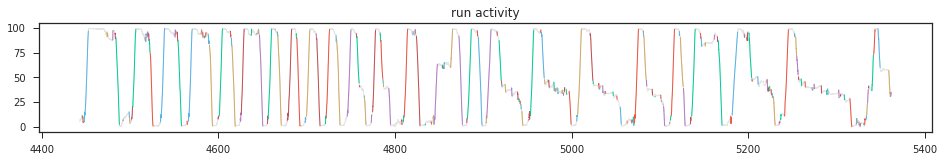

In [34]:
with npl.FigureManager(show=True, figsize=(16,2)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    plt.plot(pos1d.time, pos1d.asarray().yvals, lw=1, alpha=0.2, color='gray')
    npl.plot(pos1d[run_epochs], ax=ax, lw=1, label='run')
    
    plt.title('run activity')

In [35]:
st_run = st[run_epochs]

In [36]:
ds_run = 0.5 # 100 ms
ds_50ms = 0.05

# smooth and re-bin:
sigma = 0.3 # 300 ms spike smoothing
bst_run = st_run.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)

sigma = 0.2 # smoothing std dev in cm
tc = nel.TuningCurve1D(bst=bst_run, extern=pos1d, n_extern=50, extmin=0, extmax=100, sigma=sigma, min_duration=1)

c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:1406: UserWarning: epoch duration is less than bin size: ignoring...
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:1406: UserWarning: epoch duration is less than bin size: ignoring...
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified


In [37]:
tc = tc.reorder_units()

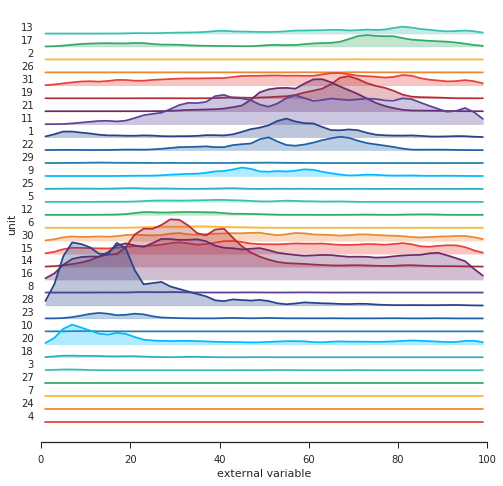

In [38]:
npl.set_palette(npl.colors.rainbow)
with npl.FigureManager(show=True, figsize=(8,8)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    npl.plot_tuning_curves1D(tc.smooth(sigma=2), normalize=False, pad=3)

### Restrict subset of cells (units) to use for subsequent decoding and/or analysis

Here we may request to use
1. unimodal cells only,
1. pyramidal cells only,
1. active cells only,
1. any combination of the above, and other criteria

Here we only impose a minimum peak firing rate of 1.5 Hz, and we reject putative interneurons by imposing a maximum average firing rate of 5 Hz averaged over the entire track.

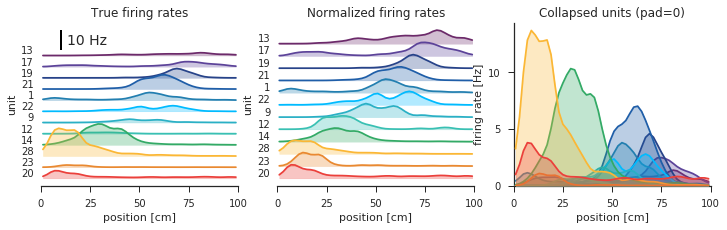

In [39]:
# set criteria for units used in decoding
min_peakfiringrate = 1 # Hz
max_avgfiringrate = 5 # Hz
peak_to_mean_ratio_threshold = 3.5 # peak firing rate should be greater than 3.5 times mean firing rate

# unimodal_cells = find_unimodal_tuningcurves1D(smoothed_rate, peakthresh=0.5)

# enforce minimum peak firing rate
unit_ids_to_keep = set(np.asanyarray(tc.unit_ids)[np.argwhere(tc.ratemap.max(axis=1)>min_peakfiringrate).squeeze().tolist()])
# enforce maximum average firing rate
unit_ids_to_keep = unit_ids_to_keep.intersection(set( np.asanyarray(tc.unit_ids)[np.argwhere(tc.ratemap.mean(axis=1)<max_avgfiringrate).squeeze().tolist()]   ))

# enforce peak to mean firing ratio
peak_firing_rates = tc.max(axis=1)
mean_firing_rates = tc.mean(axis=1)
ratio = peak_firing_rates/mean_firing_rates
unit_ids_to_keep = unit_ids_to_keep.intersection(set(np.asanyarray(tc.unit_ids)[np.argwhere(ratio>=peak_to_mean_ratio_threshold).squeeze().tolist()]))


# finally, convert remaining units into a list of indices
unit_ids_to_keep = list(unit_ids_to_keep)

# modify spike trains and ratemap to only include those units that passed all the criteria
sta_placecells = st._unit_subset(unit_ids_to_keep)

tc = tc._unit_subset(unit_ids_to_keep)

# reorder cells by peak firing location on track (this is nice for visualization, but doesn't affect decoding)
tc.reorder_units(inplace=True)

# with plt.xkcd():
with npl.palettes.color_palette(npl.colors.rainbow):
    with npl.FigureManager(show=True, nrows=1, ncols=3, figsize=(12,3)) as (fig, axes):
        npl.utils.skip_if_no_output(fig)
        ax0, ax1, ax2 = axes

        npl.plot_tuning_curves1D(tc.smooth(sigma=3), ax=ax0, pad=5.5);
        npl.plot_tuning_curves1D(tc.smooth(sigma=3), ax=ax1, normalize=True, pad=0.9);
        npl.plot_tuning_curves1D(tc.smooth(sigma=3), ax=ax2, pad=0);

        for ax in axes:
            ax.set_xlabel('position [cm]')
        npl.utils.xticks_interval(25, *axes)
        npl.utils.yticks_interval(5, ax2)
        npl.add_simple_scalebar("10 Hz", ax=ax0, xy=(10, 63), length=10, orientation='v', rotation_text='h', size=14)
#         npl.add_simple_scalebar("5 Hz", ax=ax1, xy=(10, 17.5), length=5, orientation='v', rotation_text='h', size=14)
        ax0.set_title('True firing rates', size=12)
        ax1.set_title('Normalized firing rates', size=12)
        ax2.set_title('Collapsed units (pad=0)', size=12)

## 6. Evaluate decoding performance

c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been specified
c:\etienne\dropbox\code\nelpy\nelpy\core\_spiketrain.py:361: UserWarning: unit tags have not yet been sp

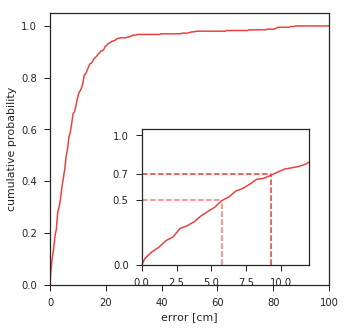

In [40]:
with npl.FigureManager(show=True, figsize=(5,5)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    
    ds_run = 0.5 # 100 ms
    ds_1ms = 0.01
#     st_run = st[run_epochs]

    # smooth and re-bin:
    bst_run = st_run.bin(ds=ds_1ms).smooth(sigma=0.5, inplace=True).rebin(w=ds_run/ds_1ms)
    
    bst = bst_run

    cumhist, bincenters = nel.decoding.cumulative_dist_decoding_error_using_xval(bst, extern=pos1d, extmax=100)
    npl.plot_cum_error_dist(bst=bst, extern=pos1d, extmin=0, extmax=100);
    
#     npl.utils.savefig('cum_error.svg')

## Some additional views

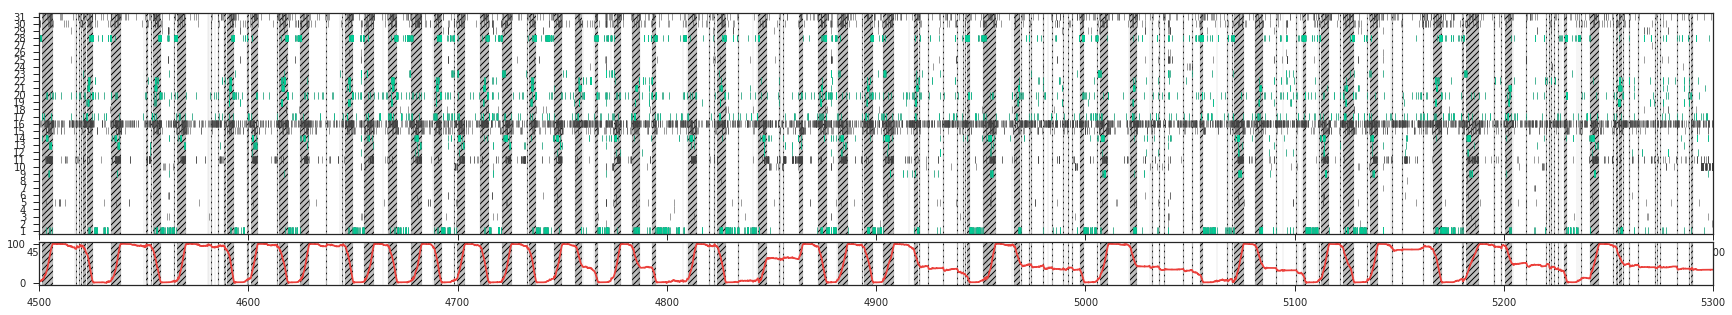

In [41]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

with npl.FigureManager(show=True, figsize=(30,5)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    
    npl.rasterplot(st, lw=0.5, ax=ax)
    npl.rasterplot(sta_placecells, lw=0.5, color=npl.colors.sweet.green)
    npl.epochplot(run_epochs)

    divider = make_axes_locatable(ax)

    axSpeed1d = divider.append_axes("bottom", size=0.6, pad=0.1)
    npl.plot(pos1d, ax=axSpeed1d)
    npl.epochplot(run_epochs, ax=axSpeed1d)

    xlims = (4500, 5300)

    ax.set_xlim(xlims)
    axSpeed1d.set_xlim(xlims)



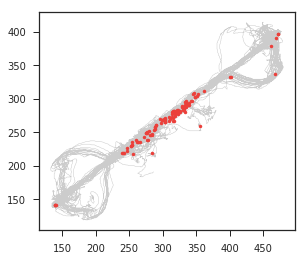

In [42]:
ax = npl.plot2d(pos, lw=0.5, c='0.8')
unit_id = 9
_, pos_at_spikes = pos.asarray(at=st[:,unit_id].time)
ax.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], '.')
ax.set_aspect('equal')

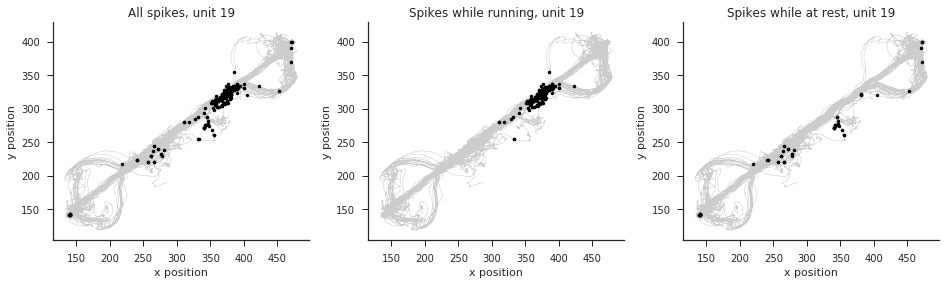

In [43]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

ax0, ax1, ax2 = axes

# plot trajectory in gray
for ax in axes:
    npl.plot2d(pos, lw=0.5, c='0.8', ax=ax)
    ax.set_aspect('equal')  
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    npl.utils.clear_right(ax)
    npl.utils.clear_top(ax)

unit_id = 19

# all spikes
at = st.loc[:,unit_id][pos.support].time
_, pos_at_spikes = pos.asarray(at=at)
ax0.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], '.', color='k')
ax0.set_aspect('equal')
ax0.set_title('All spikes, unit {}'.format(unit_id))

# spikes during RUN
at = st.loc[:,unit_id][run_epochs].time
_, pos_at_spikes = pos.asarray(at=at)
ax1.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], '.', color='k')
ax1.set_aspect('equal')
ax1.set_title('Spikes while running, unit {}'.format(unit_id))

# spikes during REST
at = st.loc[:,unit_id][~run_epochs].time
_, pos_at_spikes = pos.asarray(at=at)
ax2.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], '.', color='k')
ax2.set_aspect('equal')
ax2.set_title('Spikes while at rest, unit {}'.format(unit_id))

## Conclusion


This demo is still a work in progress, but hopefully it highlights a few ways in which using `nelpy` might make it easier to combine and analyze ephys data with different sampling rates, and different epochs where they are defined. There's a lot more that we can do with `nelpy`, so feel free to dig a little deeper to explore!

Feedback about this notebook would be appreciated, and can be sent to era3@rice.edu.